# Capacity allocation

In [ ]:
#!python3 -m pip install -e /Users/david/PycharmProjects/robin

## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behavior, get_revenue_behavior_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution
from src.timetabling_problem import MPTT

from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from mealpy.evolutionary_based import GA
from mealpy import IntegerVar
from pathlib import Path
import shutil
from typing import Any, List, Mapping, Tuple, Union

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [3]:
frame_capacity = {'1': 0.65, '2': 0.30, '3': 0.05, '4': 0}

n_services = 49
n_services_by_ru = {ru: round(cap * n_services) for ru, cap in frame_capacity.items()}

n_services_by_ru

{'1': 32, '2': 15, '3': 2, '4': 0}

In [4]:
seed = 21

if generator_config_path:
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services_by_ru=n_services_by_ru,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 49


In [5]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)
print(tsp_df)

     Number of Services
RU1                  32
RU2                  15
RU3                   2


In [6]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behavior = get_revenue_behavior_deprecated(supply)
lines = supply.lines
line = infer_line_stations(lines)

Services:  49


In [7]:
n_services = sum(tsp_df["Number of Services"].values)

services_by_ru = {}
for service in revenue_behavior:
    if revenue_behavior[service]['ru'] not in services_by_ru:
        services_by_ru[revenue_behavior[service]['ru']] = 1
    else:
        services_by_ru[revenue_behavior[service]['ru']] += 1

services_by_ru = {f"RU{k}": v for k, v in services_by_ru.items()}
print(services_by_ru)

frame_capacity = {ru: services_by_ru[ru] / n_services * 100 for ru in services_by_ru}
print(frame_capacity)

{'RU1': 32, 'RU2': 15, 'RU3': 2}
{'RU1': 65.3061224489796, 'RU2': 30.612244897959183, 'RU3': 4.081632653061225}


/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


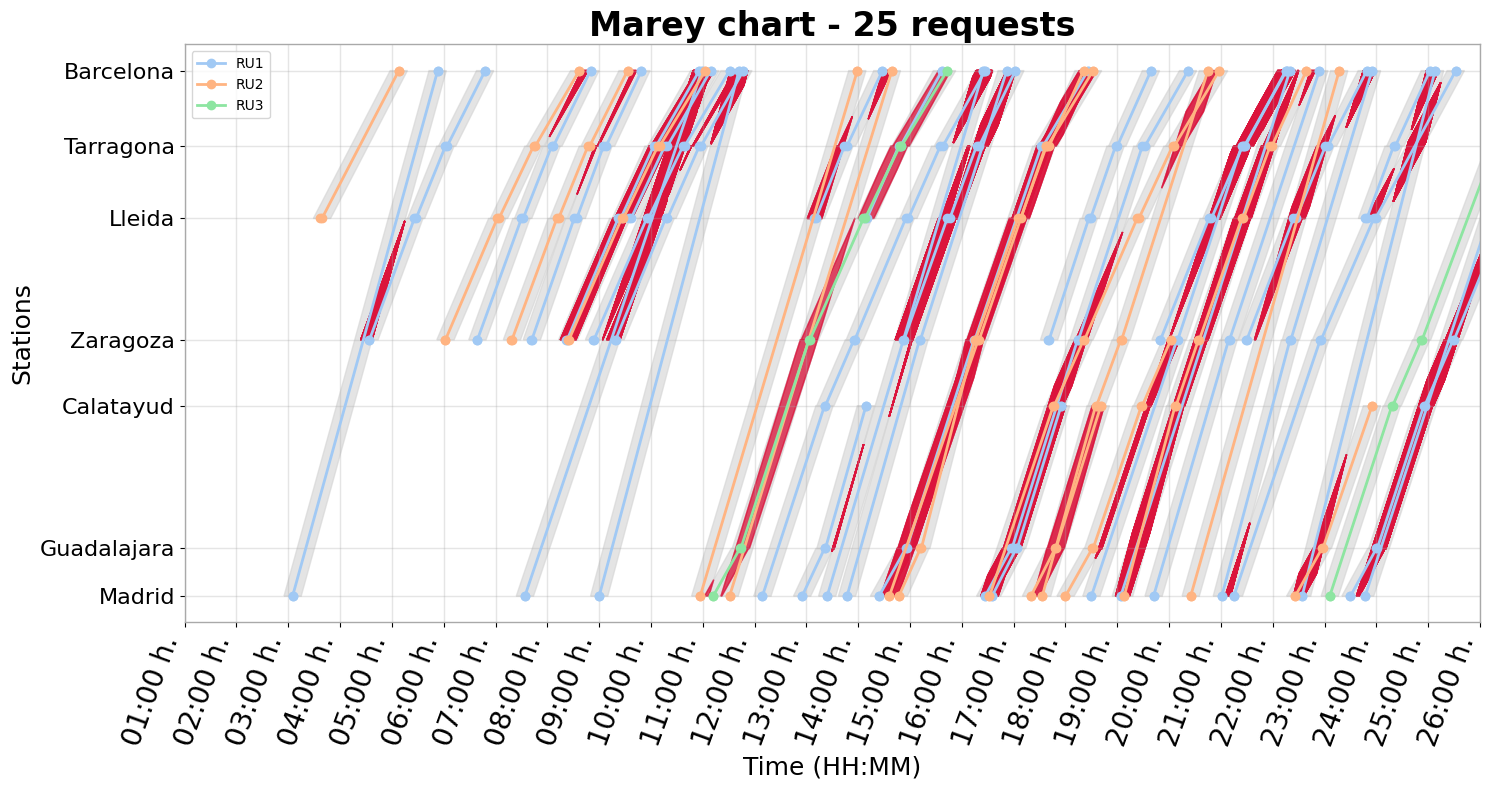

In [8]:
plot_marey_chart(requested_supply=supply,
                 colors_by_tsp=True, 
                 main_title="Marey chart - 25 requests",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_requests_25.pdf'))

## 1. Mealpy

In [9]:
# ------------------------------------------------------------------------------
# Configuration
# ------------------------------------------------------------------------------
runs = 5
epochs = 100
pop_size = 50
seed_initializer = 29
fair_indices = ["Revenue", "Jain", "Gini", "Atkinson"]

# ------------------------------------------------------------------------------
# Data Collection Containers
# ------------------------------------------------------------------------------
# Lists to accumulate history and population data from each run.
history_data = []
population_data = []

# ------------------------------------------------------------------------------
# 1. Iterate over Algorithms and Runs
# ------------------------------------------------------------------------------
for fair_index in fair_indices:
    # Reset random seed for reproducibility per algorithm
    np.random.seed(seed_initializer)
    print(f"Running {fair_index}")

    mptt = MPTT(requested_schedule=requested_schedule,
                revenue_behavior=revenue_behavior,
                line=line,
                safe_headway=10,
                fair_index=fair_index)

    # ------------------------------------------------------------------------------
    # 0. Problem Formulation
    # ------------------------------------------------------------------------------
    lb, ub = zip(*mptt.boundaries.real)
    problem = {
        "obj_func": mptt.objective_function,
        "bounds": IntegerVar(lb=lb, ub=ub),
        "minmax": "max",
        "save_population": False
    }

    for run in range(1, runs + 1):
        print(f"\tRun: {run}")
        run_seed = np.random.randint(0, 1000)

        # Initialize and run the optimizer with appropriate parameters.
        optimizer = GA.BaseGA(epoch=epochs, pop_size=pop_size)
        optimizer.solve(problem, seed=run_seed)

        # ---------------------------
        # Build History Data
        # ---------------------------
        for iteration, data in enumerate(optimizer.history.list_global_best):
            # Update schedule so that the latest heuristic schedule is available.
            mptt.update_schedule(data.solution)

            # Build a dictionary for this iteration
            history_data.append({
                "Run": run,
                "FairIndex": fair_index,
                "Iteration": iteration,
                "Fitness": data.target.fitness,
                "ExecutionTime": optimizer.history.list_epoch_time[iteration],
                "Discrete": mptt.get_heuristic_schedule_new() if fair_index != "Revenue" else mptt.get_heuristic_schedule_old(),
                "Real": data.solution,
                "Diversity": optimizer.history.list_diversity[iteration],
                "Exploitation": optimizer.history.list_exploitation[iteration],
                "Exploration": optimizer.history.list_exploration[iteration],
            })

        # ---------------------------
        # Build Population Data
        # ---------------------------
        for iteration, pop_epoch in enumerate(optimizer.history.list_population):
            real_solutions = []
            discrete_solutions = []
            for individual in pop_epoch:
                mptt.update_schedule(individual.solution)
                real_solutions.append(individual.solution)
                discrete_solutions.append(mptt.get_heuristic_schedule_new() if fair_index != "Revenue" else mptt.get_heuristic_schedule_old())

# ------------------------------------------------------------------------------
# 2. Build Final DataFrames
# ------------------------------------------------------------------------------
# Create the history DataFrame from the list of dictionaries.
df_history = pd.DataFrame(history_data)
# Optionally, enforce a specific column order:
df_history = df_history[[
    "Run", "FairIndex", "Iteration", "Fitness", "ExecutionTime",
    "Discrete", "Real", "Diversity", "Exploitation", "Exploration"
]]

2025/02/18 01:01:54 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: Solving single objective optimization problem.


Running Revenue
	Run: 1


2025/02/18 01:01:56 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 586.73011861345, Global best: 586.73011861345, Runtime: 0.98392 seconds
2025/02/18 01:01:57 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 629.5485870111647, Global best: 629.5485870111647, Runtime: 1.01239 seconds
2025/02/18 01:01:58 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 659.9008348795114, Global best: 659.9008348795114, Runtime: 1.00381 seconds
2025/02/18 01:01:59 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 740.134037188581, Global best: 740.134037188581, Runtime: 0.99411 seconds
2025/02/18 01:02:00 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 850.1724619845627, Global best: 850.1724619845627, Runtime: 0.98682 seconds
2025/02/18 01:02:01 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6, Curr

	Run: 2


2025/02/18 01:03:38 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 539.5817026904174, Global best: 539.5817026904174, Runtime: 0.96645 seconds
2025/02/18 01:03:39 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 720.3065742413319, Global best: 720.3065742413319, Runtime: 0.97454 seconds
2025/02/18 01:03:40 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 773.6878253496602, Global best: 773.6878253496602, Runtime: 0.97639 seconds
2025/02/18 01:03:40 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 754.1367820034679, Global best: 773.6878253496602, Runtime: 0.96515 seconds
2025/02/18 01:03:41 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 865.828601866154, Global best: 865.828601866154, Runtime: 0.96894 seconds
2025/02/18 01:03:42 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6, 

	Run: 3


2025/02/18 01:05:18 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 536.1491580212682, Global best: 536.1491580212682, Runtime: 0.96815 seconds
2025/02/18 01:05:19 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 638.5695866251376, Global best: 638.5695866251376, Runtime: 0.97402 seconds
2025/02/18 01:05:20 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 741.0002604766569, Global best: 741.0002604766569, Runtime: 0.97334 seconds
2025/02/18 01:05:21 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 806.4836776543559, Global best: 806.4836776543559, Runtime: 0.97058 seconds
2025/02/18 01:05:22 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 775.6231560435247, Global best: 806.4836776543559, Runtime: 0.96920 seconds
2025/02/18 01:05:23 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6

	Run: 4


2025/02/18 01:06:59 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 473.1583784021342, Global best: 473.1583784021342, Runtime: 0.97067 seconds
2025/02/18 01:07:00 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 593.7901148362112, Global best: 593.7901148362112, Runtime: 0.97080 seconds
2025/02/18 01:07:01 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 620.94945905124, Global best: 620.94945905124, Runtime: 0.97475 seconds
2025/02/18 01:07:02 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 689.4689987942015, Global best: 689.4689987942015, Runtime: 0.98094 seconds
2025/02/18 01:07:03 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 766.980698642803, Global best: 766.980698642803, Runtime: 0.97546 seconds
2025/02/18 01:07:04 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6, Curr

	Run: 5


2025/02/18 01:08:41 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 509.71747236380895, Global best: 509.71747236380895, Runtime: 0.99179 seconds
2025/02/18 01:08:42 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 555.2836145405245, Global best: 555.2836145405245, Runtime: 0.99067 seconds
2025/02/18 01:08:43 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 674.2551359148806, Global best: 674.2551359148806, Runtime: 0.99880 seconds
2025/02/18 01:08:44 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 740.8186341210476, Global best: 740.8186341210476, Runtime: 1.01424 seconds
2025/02/18 01:08:45 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 756.4179440112171, Global best: 756.4179440112171, Runtime: 1.00044 seconds
2025/02/18 01:08:46 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch:

Running Jain
	Run: 1


2025/02/18 01:10:24 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 553.9200124596587, Global best: 553.9200124596587, Runtime: 1.02550 seconds
2025/02/18 01:10:25 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 622.2474314753217, Global best: 622.2474314753217, Runtime: 1.03239 seconds
2025/02/18 01:10:26 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 598.1853382122372, Global best: 622.2474314753217, Runtime: 1.04388 seconds
2025/02/18 01:10:27 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 768.6284589216807, Global best: 768.6284589216807, Runtime: 1.04089 seconds
2025/02/18 01:10:28 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 741.606184891049, Global best: 768.6284589216807, Runtime: 1.03697 seconds
2025/02/18 01:10:29 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6,

	Run: 2


2025/02/18 01:12:12 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 521.3799712225564, Global best: 549.1117507755168, Runtime: 1.04032 seconds
2025/02/18 01:12:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 615.7499104548701, Global best: 615.7499104548701, Runtime: 1.03794 seconds
2025/02/18 01:12:14 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 734.7913855582999, Global best: 734.7913855582999, Runtime: 1.03290 seconds
2025/02/18 01:12:15 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 732.5927712486437, Global best: 734.7913855582999, Runtime: 1.05232 seconds
2025/02/18 01:12:16 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 809.2798121620749, Global best: 809.2798121620749, Runtime: 1.07516 seconds
2025/02/18 01:12:18 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6

	Run: 3


2025/02/18 01:13:59 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 540.7728696591078, Global best: 549.3746092852539, Runtime: 1.02018 seconds
2025/02/18 01:14:00 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 656.1780406346172, Global best: 656.1780406346172, Runtime: 1.02864 seconds
2025/02/18 01:14:01 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 708.4573598442014, Global best: 708.4573598442014, Runtime: 1.02925 seconds
2025/02/18 01:14:02 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 801.6002259920301, Global best: 801.6002259920301, Runtime: 1.02361 seconds
2025/02/18 01:14:03 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 859.0679455171944, Global best: 859.0679455171944, Runtime: 1.03205 seconds
2025/02/18 01:14:04 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6

	Run: 4


2025/02/18 01:15:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 531.3884705698192, Global best: 531.3884705698192, Runtime: 1.03174 seconds
2025/02/18 01:15:49 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 585.3911547723101, Global best: 585.3911547723101, Runtime: 1.03547 seconds
2025/02/18 01:15:50 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 661.5005777728381, Global best: 661.5005777728381, Runtime: 1.03501 seconds
2025/02/18 01:15:51 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 627.6932845633494, Global best: 661.5005777728381, Runtime: 1.03933 seconds
2025/02/18 01:15:52 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 643.9005564825718, Global best: 661.5005777728381, Runtime: 1.03427 seconds
2025/02/18 01:15:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6

	Run: 5


2025/02/18 01:17:35 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 631.728819971938, Global best: 631.728819971938, Runtime: 1.03079 seconds
2025/02/18 01:17:36 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 666.9935597454257, Global best: 666.9935597454257, Runtime: 1.04106 seconds
2025/02/18 01:17:37 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 638.9773258336559, Global best: 666.9935597454257, Runtime: 1.03981 seconds
2025/02/18 01:17:38 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 762.5234231072291, Global best: 762.5234231072291, Runtime: 1.03727 seconds
2025/02/18 01:17:39 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 829.2317198778351, Global best: 829.2317198778351, Runtime: 1.03615 seconds
2025/02/18 01:17:40 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6, 

Running Gini
	Run: 1


2025/02/18 01:19:21 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 632.5311978158611, Global best: 632.5311978158611, Runtime: 1.03642 seconds
2025/02/18 01:19:22 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 731.0075189838506, Global best: 731.0075189838506, Runtime: 1.03920 seconds
2025/02/18 01:19:23 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 808.074628528529, Global best: 808.074628528529, Runtime: 1.05026 seconds
2025/02/18 01:19:24 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 903.2923370831297, Global best: 903.2923370831297, Runtime: 1.04487 seconds
2025/02/18 01:19:25 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 988.6732611842986, Global best: 988.6732611842986, Runtime: 1.04457 seconds
2025/02/18 01:19:26 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6, 

	Run: 2


2025/02/18 01:21:10 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 567.4887213306288, Global best: 615.5421041212876, Runtime: 1.03563 seconds
2025/02/18 01:21:11 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 610.7623346661936, Global best: 615.5421041212876, Runtime: 1.04442 seconds
2025/02/18 01:21:12 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 778.7807340758184, Global best: 778.7807340758184, Runtime: 1.04579 seconds
2025/02/18 01:21:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 778.7807340758184, Global best: 778.7807340758184, Runtime: 1.05061 seconds
2025/02/18 01:21:14 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 836.10161347804, Global best: 836.10161347804, Runtime: 1.06759 seconds
2025/02/18 01:21:15 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6, Cu

	Run: 3


2025/02/18 01:22:57 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 622.7265265994956, Global best: 622.7265265994956, Runtime: 1.03899 seconds
2025/02/18 01:22:58 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 661.8856654266199, Global best: 661.8856654266199, Runtime: 1.03383 seconds
2025/02/18 01:22:59 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 681.1760622940517, Global best: 681.1760622940517, Runtime: 1.03324 seconds
2025/02/18 01:23:00 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 755.2060218875918, Global best: 755.2060218875918, Runtime: 1.04149 seconds
2025/02/18 01:23:01 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 789.4936474943031, Global best: 789.4936474943031, Runtime: 1.03837 seconds
2025/02/18 01:23:02 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6

	Run: 4


2025/02/18 01:24:45 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 557.2977280108503, Global best: 557.2977280108503, Runtime: 1.05903 seconds
2025/02/18 01:24:46 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 687.732620284796, Global best: 687.732620284796, Runtime: 1.06796 seconds
2025/02/18 01:24:47 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 692.7295839869118, Global best: 692.7295839869118, Runtime: 1.04058 seconds
2025/02/18 01:24:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 769.1516915529453, Global best: 769.1516915529453, Runtime: 1.04509 seconds
2025/02/18 01:24:49 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 868.8092487723802, Global best: 868.8092487723802, Runtime: 1.04338 seconds
2025/02/18 01:24:50 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6, 

	Run: 5


2025/02/18 01:26:34 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 538.4521781602996, Global best: 538.4521781602996, Runtime: 1.04447 seconds
2025/02/18 01:26:35 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 607.7686566795169, Global best: 607.7686566795169, Runtime: 1.05061 seconds
2025/02/18 01:26:36 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 772.5209002664449, Global best: 772.5209002664449, Runtime: 1.04269 seconds
2025/02/18 01:26:37 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 773.7027434855245, Global best: 773.7027434855245, Runtime: 1.05213 seconds
2025/02/18 01:26:38 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 777.6424104339878, Global best: 777.6424104339878, Runtime: 1.05251 seconds
2025/02/18 01:26:39 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6

Running Atkinson
	Run: 1


2025/02/18 01:28:25 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 548.7798473333157, Global best: 548.7798473333157, Runtime: 1.03720 seconds
2025/02/18 01:28:26 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 651.1466791844214, Global best: 651.1466791844214, Runtime: 1.04042 seconds
2025/02/18 01:28:27 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 610.4321567072782, Global best: 651.1466791844214, Runtime: 1.04187 seconds
2025/02/18 01:28:28 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 678.7252555880696, Global best: 678.7252555880696, Runtime: 1.03932 seconds
2025/02/18 01:28:29 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 765.0410737300963, Global best: 765.0410737300963, Runtime: 1.08435 seconds
2025/02/18 01:28:30 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6

	Run: 2


2025/02/18 01:30:14 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 620.5570779028692, Global best: 620.5570779028692, Runtime: 1.04710 seconds
2025/02/18 01:30:15 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 605.8532008316638, Global best: 620.5570779028692, Runtime: 1.04152 seconds
2025/02/18 01:30:16 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 631.2249053627381, Global best: 631.2249053627381, Runtime: 1.03793 seconds
2025/02/18 01:30:17 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 651.8435957943309, Global best: 651.8435957943309, Runtime: 1.03785 seconds
2025/02/18 01:30:18 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 704.621928339983, Global best: 704.621928339983, Runtime: 1.03842 seconds
2025/02/18 01:30:19 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6, 

	Run: 3


2025/02/18 01:32:01 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 582.5293822799849, Global best: 582.5293822799849, Runtime: 1.02135 seconds
2025/02/18 01:32:02 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 647.3000598858421, Global best: 647.3000598858421, Runtime: 1.03722 seconds
2025/02/18 01:32:03 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 659.5461008400741, Global best: 659.5461008400741, Runtime: 1.03413 seconds
2025/02/18 01:32:04 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 679.6026125156181, Global best: 679.6026125156181, Runtime: 1.03642 seconds
2025/02/18 01:32:05 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 721.7995054627684, Global best: 721.7995054627684, Runtime: 1.04478 seconds
2025/02/18 01:32:06 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6

	Run: 4


2025/02/18 01:33:49 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 564.1350289200288, Global best: 564.1350289200288, Runtime: 1.03931 seconds
2025/02/18 01:33:50 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 551.9231868261561, Global best: 564.1350289200288, Runtime: 1.04862 seconds
2025/02/18 01:33:51 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 601.9678129698491, Global best: 601.9678129698491, Runtime: 1.04613 seconds
2025/02/18 01:33:52 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 606.2960771352919, Global best: 606.2960771352919, Runtime: 1.04638 seconds
2025/02/18 01:33:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 665.3417411041248, Global best: 665.3417411041248, Runtime: 1.04444 seconds
2025/02/18 01:33:54 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6

	Run: 5


2025/02/18 01:35:40 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 613.653224145997, Global best: 613.653224145997, Runtime: 1.05847 seconds
2025/02/18 01:35:41 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 591.0707689757032, Global best: 613.653224145997, Runtime: 1.06776 seconds
2025/02/18 01:35:42 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 621.0348371591631, Global best: 621.0348371591631, Runtime: 1.04829 seconds
2025/02/18 01:35:43 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 684.9551492681292, Global best: 684.9551492681292, Runtime: 1.05278 seconds
2025/02/18 01:35:44 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 697.8132523347253, Global best: 697.8132523347253, Runtime: 1.04217 seconds
2025/02/18 01:35:45 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 6, C

## 2. Results analysis

In [10]:
reports_path = Path('../reports/mealpy/')

In [11]:
df_history.to_csv(reports_path / 'df_history_equity_18_feb_25_alpha.csv', sep=";", index=False)

In [12]:
df_history = pd.read_csv(reports_path / 'df_history_equity_18_feb_25_alpha.csv', sep=";")

In [13]:
df_history

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Revenue,0,586.730119,0.983922,[ True True False True False False False Tr...,[1041. 1114. 1146. 1409. 1441. 1502. 1533. 159...,11.873798,0.000000,100.000000
1,1,Revenue,1,629.548587,1.012391,[ True True True True False False False Tr...,[1006. 1114. 1147. 1409. 1449. 1497. 1539. 159...,10.012093,15.679106,84.320894
2,1,Revenue,2,659.900835,1.003813,[ True True False True False False False Tr...,[1061. 1114. 1146. 1430. 1449. 1498. 1538. 159...,7.631318,35.729768,64.270232
3,1,Revenue,3,740.134037,0.994105,[ True True True True False False False Tr...,[1041. 1114. 1147. 1409. 1441. 1497. 1539. 159...,6.515349,45.128352,54.871648
4,1,Revenue,4,850.172462,0.986817,[ True True True True False False False Tr...,[1041. 1114. 1146. 1409. 1441. 1497. 1539. 159...,5.653798,52.384248,47.615752
...,...,...,...,...,...,...,...,...,...,...
1995,5,Atkinson,95,1200.007886,1.045098,[ True False True False False False False Tr...,[1056. 1109. 1143. 1351. 1444. 1496. 1537. 159...,2.181085,81.662952,18.337048
1996,5,Atkinson,96,1200.007886,1.038383,[ True False True False False False False Tr...,[1056. 1109. 1143. 1351. 1444. 1496. 1537. 159...,2.203876,81.471343,18.528657
1997,5,Atkinson,97,1200.007886,1.035173,[ True False True False False False False Tr...,[1056. 1109. 1143. 1351. 1444. 1496. 1537. 159...,2.155349,81.879326,18.120674
1998,5,Atkinson,98,1200.007886,1.043611,[ True False True False False False False Tr...,[1056. 1109. 1143. 1351. 1444. 1496. 1537. 159...,2.340775,80.320390,19.679610


In [14]:
columns_to_transform = df_history.filter(like="Real").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(float, x[1:-1].split())), dtype=np.int32))
)

df_history.head()

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Revenue,0,586.730119,0.983922,[ True True False True False False False Tr...,"[1041, 1114, 1146, 1409, 1441, 1502, 1533, 159...",11.873798,0.000000,100.000000
1,1,Revenue,1,629.548587,1.012391,[ True True True True False False False Tr...,"[1006, 1114, 1147, 1409, 1449, 1497, 1539, 159...",10.012093,15.679106,84.320894
2,1,Revenue,2,659.900835,1.003813,[ True True False True False False False Tr...,"[1061, 1114, 1146, 1430, 1449, 1498, 1538, 159...",7.631318,35.729768,64.270232
3,1,Revenue,3,740.134037,0.994105,[ True True True True False False False Tr...,"[1041, 1114, 1147, 1409, 1441, 1497, 1539, 159...",6.515349,45.128352,54.871648
4,1,Revenue,4,850.172462,0.986817,[ True True True True False False False Tr...,"[1041, 1114, 1146, 1409, 1441, 1497, 1539, 159...",5.653798,52.384248,47.615752


In [15]:
columns_to_transform = df_history.filter(like="Discrete").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(lambda s: True if s == "True" else False, x[1:-1].split())), dtype=bool))
)

df_history.head()

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Revenue,0,586.730119,0.983922,"[True, True, False, True, False, False, False,...","[1041, 1114, 1146, 1409, 1441, 1502, 1533, 159...",11.873798,0.000000,100.000000
1,1,Revenue,1,629.548587,1.012391,"[True, True, True, True, False, False, False, ...","[1006, 1114, 1147, 1409, 1449, 1497, 1539, 159...",10.012093,15.679106,84.320894
2,1,Revenue,2,659.900835,1.003813,"[True, True, False, True, False, False, False,...","[1061, 1114, 1146, 1430, 1449, 1498, 1538, 159...",7.631318,35.729768,64.270232
3,1,Revenue,3,740.134037,0.994105,"[True, True, True, True, False, False, False, ...","[1041, 1114, 1147, 1409, 1441, 1497, 1539, 159...",6.515349,45.128352,54.871648
4,1,Revenue,4,850.172462,0.986817,"[True, True, True, True, False, False, False, ...","[1041, 1114, 1146, 1409, 1441, 1497, 1539, 159...",5.653798,52.384248,47.615752


In [17]:
import itertools

mptt = MPTT(
    requested_schedule=requested_schedule,
    revenue_behavior=revenue_behavior,
    line=line,
    safe_headway=10,
    fair_index="Revenue"
)

# Mapeo de servicios a nombres de RU (por ejemplo, "RU1", "RU2", etc.)
service_tsps = {service.id: service.tsp.name for service in supply.services}
ru_names = sorted(set(service_tsps.values()))

# Definir las columnas del nuevo DataFrame:
# FairIndex, Run, Revenue, Execution Time (s.), Scheduled Trains + una columna por cada RU
columns = ['FairIndex', 'Run', 'Fitness', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains'] + ru_names + ['Total Importance', 'Pairwise Differences']
summary_df = pd.DataFrame(columns=columns)

# Agrupar el historial por FairIndex y luego por Run
algo_grouped_df = df_history.groupby('FairIndex')

for algo_key, algo_group in algo_grouped_df:
    run_grouped_df = algo_group.groupby('Run')
    for run_label, run_group in run_grouped_df:
        run = run_group['Run'].iloc[-1]
        fitness = np.round(run_group['Fitness'].iloc[-1], 2)
        revenue = mptt.objective_function(run_group['Real'].iloc[-1], alpha=1)
        execution_time = np.round(run_group['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_group['Discrete'].iloc[-1]
        scheduled_trains = int(sum(scheduled_trains_array))
        real_solution = run_group['Real'].iloc[-1]

        # Actualizamos la planificación (por si el método .sum_importance() depende de ello)
        mptt.update_schedule(real_solution)

        # Obtener el diccionario de importancias (por RU) a partir del vector booleano de servicios planificados.
        importance_dict = mptt.sum_importance(scheduled_trains_array)
        importance_dict = {f'RU{k}': v for k, v in importance_dict.items()}

        total_importance = sum(importance_dict.values())

        # Calcular la suma de diferencias absolutas pairwise entre las importancias.
        pairwise_diff = 0
        for ru1, ru2 in itertools.combinations(ru_names, 2):
            pairwise_diff += abs(importance_dict.get(ru1, 0) - importance_dict.get(ru2, 0))

        # Construir la fila de datos:
        row_data = [
            algo_key,
            run,
            fitness,
            revenue,
            execution_time,
            scheduled_trains
        ]

        # Agregar, para cada RU (ordenados alfabéticamente), el valor de suma de importancia.
        for ru in ru_names:
            # Si no existe valor para algún RU, se asigna 0
            row_data.append(importance_dict.get(ru, 0))

        # Agregar la columna de Total Importance
        row_data.append(total_importance)
        # Agregar la columna de Pairwise Differences
        row_data.append(pairwise_diff)

        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Pairwise Differences', ascending=True)
display(summary_df)
print()

,FairIndex,Run,Fitness,Revenue,Execution Time (s.),Scheduled Trains,RU1,RU2,RU3,Total Importance,Pairwise Differences
16,Revenue,2,1433.44,7167.195491,98.07,28,0.519750,0.710812,0.507617,1.738178,0.406390
18,Revenue,4,1419.30,7096.482607,99.35,29,0.565376,0.710333,0.492383,1.768093,0.435900
19,Revenue,5,1316.67,6583.355513,100.30,28,0.509279,0.719369,0.492383,1.721032,0.453972
8,Gini,4,1455.62,4773.103950,106.28,29,0.548404,0.789871,0.492383,1.830658,0.594975
10,Jain,1,1311.68,4359.369410,105.31,27,0.512936,0.812070,0.492383,1.817389,0.639373
3,Atkinson,4,1174.90,3521.670233,108.31,26,0.492577,0.833617,0.492383,1.818577,0.682468
5,Gini,1,1573.38,4901.503365,106.03,26,0.486498,0.833617,0.492383,1.812498,0.694239
1,Atkinson,2,1127.09,3790.696188,104.67,27,0.503165,0.846020,0.492383,1.841568,0.707273
0,Atkinson,1,1242.74,4924.727823,105.89,27,0.462319,0.826148,0.492383,1.780851,0.727657
7,Gini,3,1452.95,4367.964679,105.14,25,0.449532,0.833617,0.492383,1.775532,0.768171


In [20]:
# Table with results by run

mptt = MPTT(requested_schedule=requested_schedule,
                revenue_behavior=revenue_behavior,
                line=line,
                safe_headway=10,
                fair_index="Revenue")

service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['FairIndex', 'Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += sorted(set(service_tsps.values()))
columns += [f"{tsp}_equity" for tsp in sorted(set(service_tsps.values()))]
summary_df = pd.DataFrame(columns=columns)

algo_grouped_df = df_history.groupby('FairIndex')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        revenue = np.round(run_grouped_df.get_group(group)['Fitness'].iloc[-1], 2)
        execution_time = np.round(run_grouped_df.get_group(group)['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        mptt.update_schedule(real_solution)
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in sorted(service_tsps.values())}
        for i, service in enumerate(mptt.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(mptt.requested_schedule[service].keys())[0]
            delta_dt += abs(mptt.updated_schedule[service][departure_station][1] -
                            mptt.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(mptt.requested_schedule[service].keys()):
                if j == 0 or j == len(mptt.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(mptt.updated_schedule[service][stop][1] - mptt.requested_schedule[service][stop][1])
    
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1
    
        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100, 2)} %"

        frame_capacity_dict = {}
        for tsp in services_by_tsp:
            frame_capacity_dict[f"{tsp}_equity"] = f"{np.round(services_by_tsp[tsp] / 25 * 100, 2)}"

        row_data =  [algo_group[0],
                     run,
                     revenue,
                     execution_time,
                     scheduled_trains,
                     np.round(delta_dt, 2),
                     np.round(delta_tt, 2),
                     *list(percentages_by_tsp.values()),
                     *list(frame_capacity_dict.values())]
        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)
print()

,FairIndex,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),RU1,RU2,RU3,RU1_equity,RU2_equity,RU3_equity
6,Revenue,2,7167.20,99.26,28,395.0,181.0,50.0 %,73.33 %,50.0 %,64.0,44.0,4.0
8,Revenue,4,7096.48,102.10,29,463.0,192.0,56.25 %,66.67 %,50.0 %,72.0,40.0,4.0
5,Revenue,1,6798.94,101.98,26,380.0,184.0,43.75 %,66.67 %,100.0 %,56.0,40.0,8.0
9,Revenue,5,6583.36,101.05,28,357.0,190.0,50.0 %,73.33 %,50.0 %,64.0,44.0,4.0
7,Revenue,3,5955.93,100.14,27,294.0,138.0,50.0 %,73.33 %,0.0 %,64.0,44.0,0.0
1,Jain,2,5712.53,105.30,26,276.0,142.0,53.12 %,53.33 %,50.0 %,68.0,32.0,4.0
3,Jain,4,5193.51,104.48,24,252.0,122.0,46.88 %,53.33 %,50.0 %,60.0,32.0,4.0
2,Jain,3,5177.93,104.51,24,149.0,94.0,53.12 %,40.0 %,50.0 %,68.0,24.0,4.0
0,Jain,1,4997.63,106.62,23,168.0,77.0,46.88 %,46.67 %,50.0 %,60.0,28.0,4.0
4,Jain,5,4833.82,103.70,23,225.0,78.0,50.0 %,40.0 %,50.0 %,64.0,24.0,4.0


In [ ]:
frame_capacity

In [ ]:
# Supongamos que frame_capacity_target es un diccionario como:

sm = RevenueMaximization(
    requested_schedule=requested_schedule,
    revenue_behavior=revenue_behavior,
    line=line,
    safe_headway=10
)

# Diccionario para relacionar cada servicio con el nombre de su RU.
service_tsps = {service.id: service.tsp.name for service in supply.services}

# Definir las columnas del dataframe de resumen.
base_columns = ['FairIndex', 'Run', 'Revenue', 'Execution Time (s.)',
                'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)', 'Overall Fairness']
# Ordenamos alfabéticamente los nombres de RU
ru_names = sorted(set(service_tsps.values()))
# Se añaden columnas con el porcentaje alcanzado (a nivel de RU) y
# columnas informativas con el nombre _equity para cada RU.
summary_columns = base_columns + ru_names + [f"{tsp}_equity" for tsp in ru_names]
summary_df = pd.DataFrame(columns=summary_columns)

# Agrupamos df_history por FairIndex (cada grupo corresponde a un método/algoritmo)
algo_grouped_df = df_history.groupby('FairIndex')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for run_label, run_group in run_grouped_df:
        # Extraer valores de la ejecución
        run = run_group['Run'].iloc[-1]
        revenue = np.round(run_group['Fitness'].iloc[-1], 2)
        execution_time = np.round(run_group['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_group['Discrete'].iloc[-1]
        scheduled_trains = int(sum(scheduled_trains_array))
        real_solution = run_group['Real'].iloc[-1]

        # Actualizar la planificación con la solución real (se ignoran los servicios no programados)
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains_array))
        delta_dt = 0.0
        delta_tt = 0.0

        # Inicializar contadores para cada RU (por ejemplo, 'RU1', 'RU2', etc.)
        services_by_tsp = {tsp: 0 for tsp in ru_names}

        # Para cada servicio del plan solicitado, si está programado se acumulan los deltas y se cuenta la RU
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            # Para el primer stop se calcula el delta en DT
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(
                sm.updated_schedule[service][departure_station][1] -
                sm.requested_schedule[service][departure_station][1]
            )
            # Para los stops intermedios se acumulan los deltas en TT
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(
                    sm.updated_schedule[service][stop][1] -
                    sm.requested_schedule[service][stop][1]
                )
            # Incrementar contador según el RU del servicio
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1

        # Calcular el porcentaje alcanzado para cada RU comparando con su capacidad marco.
        # Por ejemplo, si para 'RU1' se programaron 15 servicios y la capacidad marco es 30, se alcanza el 50%.
        percentages_by_tsp = {}
        ru_equity = {}  # Almacenará el valor numérico (por ejemplo, 50.0) para cada RU
        for tsp in ru_names:
            target = services_by_ru[tsp]  # capacidad marco del RU
            achieved = services_by_tsp[tsp]
            percentage = np.round(achieved / target * 100, 2) if target != 0 else 0.0
            percentages_by_tsp[tsp] = f"{percentage} %"
            ru_equity[tsp] = percentage

        # Calcular el índice de equidad global (Overall Fairness) usando la fórmula de Jain:
        # J = (sum(r_i)^2) / (n * sum(r_i^2))
        r_values = list(ru_equity.values())
        n = len(r_values)
        sum_r = sum(r_values)
        sum_r_sq = sum([r**2 for r in r_values])
        overall_fairness = (sum_r**2) / (n * sum_r_sq) if sum_r_sq != 0 else 0

        # Preparar la fila de datos. Se agregan:
        # - Las métricas generales
        # - Para cada RU, el porcentaje alcanzado (según el orden en ru_names)
        # - Para cada RU, se incluye una columna con el nombre <RU>_equity que muestra el mismo valor numérico
        row_data = [
            algo_group[0],            # FairIndex (método)
            run,
            revenue,
            execution_time,
            scheduled_trains,
            np.round(delta_dt, 2),
            np.round(delta_tt, 2),
            np.round(overall_fairness, 4)  # Se puede multiplicar por 100 si se prefiere porcentaje
        ]
        # Agregar los porcentajes por RU
        for tsp in ru_names:
            row_data.append(percentages_by_tsp[tsp])
        # Agregar las columnas de _equity (se puede mostrar el valor numérico)
        for tsp in ru_names:
            row_data.append(ru_equity[tsp])

        # Añadir la fila al dataframe resumen
        summary_df.loc[len(summary_df)] = row_data

# Ordenar el dataframe de salida según el Overall Fairness de forma descendente
summary_df = summary_df.sort_values('Overall Fairness', ascending=False)
display(summary_df)
print()


In [ ]:
summary_df.to_latex()

In [ ]:
# Global status

def get_global_status(df: pd.DataFrame):
    algo_grouped_df = df.groupby('FairIndex')

    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')
        
        print(f"Global {algo_group[0]} status:")
        
        # Execution time (mean and std.)
        run_times = run_grouped_df['ExecutionTime'].last()
        print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
        print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
        
        # Revenue (mean and std.)
        run_revenues = run_grouped_df['Fitness'].last()
        print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
        
        # Scheduled trains (mean and std.)
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
        
        max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
        print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
        print()
        
get_global_status(df_history)

In [ ]:

def get_global_status_as_dataframe(df: pd.DataFrame):
    algo_grouped_df = df.groupby('FairIndex')
    
    results = []
    for algo_name, algo_group in algo_grouped_df:
        run_grouped_df = algo_group.groupby('Run')
        
        run_times = run_grouped_df['ExecutionTime'].sum()
        
        run_revenues = run_grouped_df['Fitness'].last()
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        
        result = {
            'FairIndex': algo_name,
            'Mean Execution Time (seconds)': round(run_times.mean(), 2),
            'Std Execution Time (seconds)': round(run_times.std(), 2),
            'Mean Fitness (revenue)': round(run_revenues.mean(), 2),
            'Std Fitness (revenue)': round(run_revenues.std(), 2),
            'Mean Scheduled Trains': int(round(run_trains.mean())),
            'Std Scheduled Trains': int(round(run_trains.std()))
        }
        
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    # Short by column 'Mean Fitness' 
    results_df = results_df.sort_values(by='Mean Fitness (revenue)', ascending=False).reset_index(drop=True)
    return results_df

results_df = get_global_status_as_dataframe(df_history)
results_df

In [ ]:
results_df.to_latex()

In [ ]:
sns_line_plot(df=df_history,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Convergence curves",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 100),
              y_limit=(1500,4500),
              save_path=Path('../reports/mealpy/mealpy_convergence_equity.pdf'),
              fig_size=(10, 9))

In [ ]:
df_history.head()

In [ ]:
N = 50  # Número de saltos que quieres aplicar

algo_1_vals = df_history[df_history['Algo'] == 'Simulated Annealing'] \
    .groupby(['Run', 'Iteration'])['Fitness'].last() \
    .groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()

algo_1_vals

In [ ]:
algo_df = df_history[df_history['Algo'] == 'Genetic Algorithm']

algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()

algo_vals

In [ ]:
print(len(algo_vals))

In [ ]:
algo_df = df_history[df_history['Algo'] == 'Simulated Annealing']

N = 50
algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()

algo_vals

In [ ]:
print(len(algo_vals))

In [ ]:
# Confusion Matrix stadistical differences 

from scipy import stats

def get_epoch_last_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(list).sum()
    else:
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()
    return algo_vals

def get_epoch_best_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()
    else:
        algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()
    return algo_vals

matrix_wilcoxon = []
matrix_p_values = []
for algo_name, algo in mp_algos.items():
    row_w = []
    row_p = []
    for algo_name_2, algo_2 in mp_algos.items():
        if algo_name == algo_name_2:
            row_w.append(np.nan)
            row_p.append(np.nan)
            continue
        
        algo_1_vals = get_epoch_best_fitness(df_history, algo_name)
        algo_2_vals = get_epoch_best_fitness(df_history, algo_name_2)
        stat, p_value = stats.wilcoxon(algo_1_vals, algo_2_vals)
        row_w.append(round(stat))
        row_p.append(round(p_value, 3))
    matrix_wilcoxon.append(row_w)
    matrix_p_values.append(row_p)

In [ ]:
print("Wilcoxon Matrix")
df_wilcoxon = pd.DataFrame(matrix_wilcoxon, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_wilcoxon)

In [ ]:
print("P-Values Matrix")
df_p_values = pd.DataFrame(matrix_p_values, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_p_values)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df_wilcoxon, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_wilcoxon.columns, rotation=30, ha='right')
plt.yticks(range(10), df_wilcoxon.index)
plt.title('Confusion Matrix - Wilcoxon Statistic', fontweight='bold', fontsize=18)

for i in range(df_wilcoxon.shape[0]):
    for j in range(df_wilcoxon.shape[1]):
        value = df_wilcoxon.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{int(value)}"
            text_color = 'black' if value > 50000 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/wilcoxon_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
# Visualización con matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(df_p_values, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_p_values.columns, rotation=30, ha='right')
plt.yticks(range(10), df_p_values.index)
plt.title('Confusion Matrix - P-values', fontweight='bold', fontsize=18)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.4 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(12, 10))
plt.imshow(df_p_values, cmap='seismic', interpolation='nearest')
plt.colorbar(label='P-value', shrink=0.8)
plt.xticks(range(df_p_values.shape[1]), df_p_values.columns, rotation=45, ha='right', fontsize=10)
plt.yticks(range(df_p_values.shape[0]), df_p_values.index, fontsize=10)
plt.title('Matrix of P-values Between Algorithms', fontweight='bold', fontsize=20)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            display_value = "NaN"
            text_color = 'white'
            rect_color = (0.5, 0.5, 0.5)
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.3 and value < 0.7 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color, fontsize=8)

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, df_p_values.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, df_p_values.shape[0], 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_improved.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
stat, p_value = stats.wilcoxon(genetic_revenues_mean, acor_revenues_mean)
print(f"Estadístico de Wilcoxon: {stat}, Valor p: {p_value}")

In [ ]:
# Select a solution from df_history:
algo_name = 'Genetic Algorithm'
run = 1
iteration = 99

filtered_row = df_history[
    (df_history["Algo"] == algo_name) &
    (df_history["Run"] == run) &
    (df_history["Iteration"] == iteration)
]

# Get values from columns "Real" & "Discrete"
if not filtered_row.empty:
    real_value = filtered_row["Real"].iloc[0]
    discrete_value = filtered_row["Discrete"].iloc[0]
    ga_best_sol = Solution(real=real_value, discrete=discrete_value)
    print(f"Real: {real_value}, Discrete: {discrete_value}")
else:
    print("Row not found matching the provided parameters.")

In [ ]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behavior=revenue_behavior,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=ga_best_sol)

sm.update_schedule(solution=ga_best_sol)

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if ga_best_sol.discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)

# Copy previous file in reports
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'{tt_file_name}_25_new.yml')

supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

In [ ]:
final_supply = Supply.from_yaml(supply_config_file)

In [ ]:
plot_marey_chart(requested_supply=final_supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_ga_25.pdf'))

In [ ]:
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'{tt_file_name}_equity.yml')

In [ ]:
#!snakeviz profile.pstat